In [47]:
# read in wrfout files

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import glob
import wrf
from netCDF4 import Dataset
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

site_latitude  = 36.6050
site_longitude = -97.485

# wrf_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
# wrf_runs_dir = '/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/'
wrf_runs_dir = '/scratch/jlee/mmc/'

# wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/l1_0805m/'
# wrf_path = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/l5_0805m/'

nb_dir = !pwd
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

obs_dir = '/home/jlee/mmc/jlee/sgp/sgp_obs/'
ceil_ncs = obs_dir+'sgppblhtdlC1.c1/*.nc'
ceil = xr.open_mfdataset(ceil_ncs)

In [52]:
ceil

<xarray.Dataset>
Dimensions:           (bound: 2, height: 133, time: 4752)
Coordinates:
  * time              (time) datetime64[ns] 2018-08-01 ... 2018-09-02T23:50:00
  * height            (height) float32 15.0 45.0 75.0 ... 3.945e+03 3.975e+03
Dimensions without coordinates: bound
Data variables:
    base_time         (time) datetime64[ns] 2018-08-01 2018-08-01 ... 2018-09-02
    time_offset       (time) datetime64[ns] dask.array<chunksize=(144,), meta=np.ndarray>
    time_bounds       (time, bound) datetime64[ns] dask.array<chunksize=(144, 2), meta=np.ndarray>
    pbl_height_dl     (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    qc_pbl_height_dl  (time) int32 dask.array<chunksize=(144,), meta=np.ndarray>
    dl_cbh            (time) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    snr               (time, height) float32 dask.array<chunksize=(144, 133), meta=np.ndarray>
    w_variance        (time, height) float32 dask.array<chunksize=(144, 133), meta=np.ndarray>
    lat               (time) float32 36.6 36.6 36.6 36.6 ... 36.6 36.6 36.6 36.6
    lon               (time) float32 -97.49 -97.49 -97.49 ... -97.49 -97.49
    alt               (time) float32 318.0 318.0 318.0 ... 318.0 318.0 318.0
Attributes:
    command_line:          idl -R -n pblhtdl -s sgp -f C1 -b 20101023 -e 2020...
    Conventions:           ARM-1.3
    process_version:       vap-pblhtdl-0.0-0.dev0.dirty.el7
    dod_version:           pblhtdl-c1-1.0
    input_datastreams:     sgparsclkazr1kolliasC1.c0 : 1.2 : 20180801.000000\...
    site_id:               sgp
    platform_id:           pblhtdl
    facility_id:           C1
    data_level:            c1
    location_description:  Southern Great Plains (SGP), Lamont, Oklahoma
    datastream:            sgppblhtdlC1.c1
    doi:                   10.5439/1726254
    history:               created by user sivaraman on machine emerald.adc.a...

In [3]:
data_dir_df

,2018-08-05,2018-09-01
mynn,a1_0805m_30s,o1_0901m_30s
mynn_ck0.1,l7_0805m-ck,NaN
mynn_ml1,a3_0805m_30s_mixlen1,NaN
mynn_all4d-1arcs-topo,l5_0805m,NaN
mynn_d12-9s_d34-1s,a5_0805m_9s1s,o5_0901m_9s1s
mynn_d123-9s_d4-1s_lu,n2_d123-9s_d4-1s,NaN
mynn_all4d-9arcs_lu,n3_9s,NaN
mynn_d12-9s_d34-1s_ml1,a7_0805m_9s1s_mixlen1,o7_0901m_9s1s_mixlen1
mynn_d12-9s_d34-1s_ml0,a71_0805m_9s1s_mixlen0,NaN
mynn_d12-9s_d34-1s_ck0.1,a9_0805m_9s1s_ck01,NaN


In [12]:
def get_pblh(wrf_path, domain): 
    
    wrf_file_list = glob.glob(wrf_runs_dir+wrf_path+'/wrfout_d0'+str(domain)+'*')
    
    print(wrf_runs_dir+wrf_path)

    for ind, file in enumerate(wrf_file_list):

        wrf_single = Dataset(file, 'r')

        site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)

        pblh = wrf.getvar(wrf_single, 'PBLH')
        pblh_1pt = pblh[site_loc_ij.values[1], site_loc_ij.values[0]]

        if ind == 0: 
            pblh_1pt_all = pblh_1pt
        else: 
            pblh_1pt_all = xr.concat([pblh_1pt, pblh_1pt_all], dim='Time')

    return pblh_1pt_all.sortby('Time')

In [41]:
def plot_d02pblh(eval_date, wrf_list):

    for run in wrf_list:

        pblh_d02 = get_pblh(data_dir_df[eval_date][run], 2)

        plt.plot(pblh_d02['Time'], pblh_d02, label=run)

    plt.tick_params(axis='x', rotation=90)    
    plt.ylabel('PBLH (m)')
    plt.xlim(np.datetime64('2018-08-05T13:00:00.000000000'), np.datetime64('2018-08-06T00:00:00.000000000'))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

/scratch/jlee/mmc/a1_0805m_30s
/scratch/jlee/mmc/a2_0805e_30s
/scratch/jlee/mmc/a2a_0805e_30s_mixlen1
/scratch/jlee/mmc/a2b_0805e_30s_mixlen0


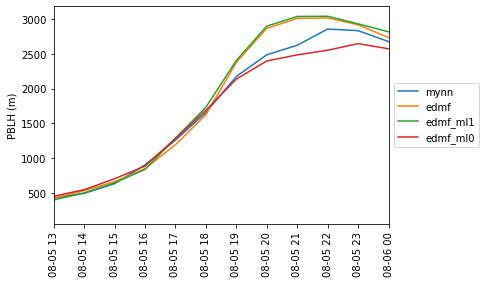

In [49]:
eval_date = '2018-08-05'
wrf_list = ['mynn', 'edmf', 'edmf_ml1', 'edmf_ml0']
plot_d02pblh(eval_date, wrf_list)

/scratch/jlee/mmc/a1_0805m_30s
/scratch/jlee/mmc/a5_0805m_9s1s
/scratch/jlee/mmc/a2_0805e_30s
/scratch/jlee/mmc/a6_0805e_9s1s


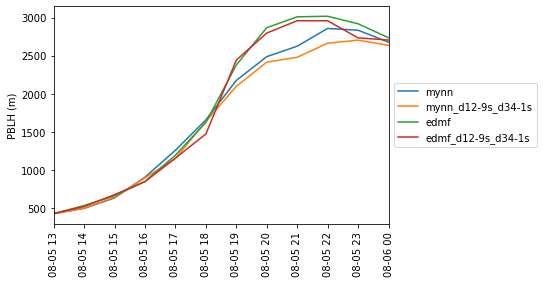

In [43]:
wrf_list = ['mynn', 'mynn_d12-9s_d34-1s', 
            'edmf', 'edmf_d12-9s_d34-1s']
plot_d02pblh(eval_date, wrf_list)

/scratch/jlee/mmc/a2_0805e_30s
/scratch/jlee/mmc/a2a_0805e_30s_mixlen1
/scratch/jlee/mmc/a2b_0805e_30s_mixlen0
/scratch/jlee/mmc/a6_0805e_9s1s
/scratch/jlee/mmc/a8_0805e_9s1s_mixlen1
/scratch/jlee/mmc/a8b_0805e_9s1s_mixlen0


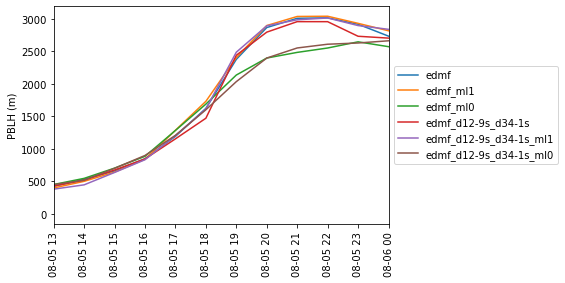

In [45]:
wrf_list = ['edmf', 'edmf_ml1', 'edmf_ml0', 
            'edmf_d12-9s_d34-1s', 'edmf_d12-9s_d34-1s_ml1', 'edmf_d12-9s_d34-1s_ml0']
plot_d02pblh(eval_date, wrf_list)

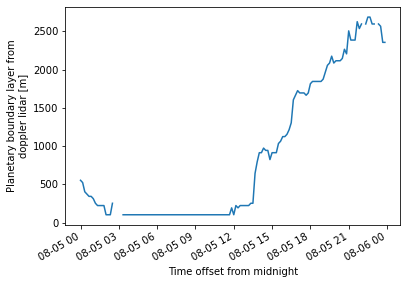

In [51]:
# eval_date = '2018-09-01'
ceil_target = ceil.sel(time=slice(eval_date, eval_date))
ceil_target['pbl_height_dl'].where(ceil_target['qc_pbl_height_dl'] <= 0).plot()

/scratch/jlee/mmc/a5_0805m_9s1s
/scratch/jlee/mmc/a6_0805e_9s1s
/scratch/jlee/mmc/a8_0805e_9s1s_mixlen1
/scratch/jlee/mmc/a8b_0805e_9s1s_mixlen0


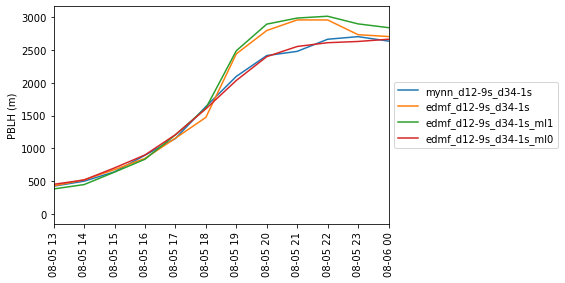

In [39]:
eval_date = '2018-08-05'

wrf_list = ['mynn_d12-9s_d34-1s', 'edmf_d12-9s_d34-1s', 'edmf_d12-9s_d34-1s_ml1', 'edmf_d12-9s_d34-1s_ml0']

for run in wrf_list:
    
    pblh_d02 = get_pblh(data_dir_df[eval_date][run], 2)

    plt.plot(pblh_d02['Time'], pblh_d02, label=run)

plt.tick_params(axis='x', rotation=90)    
plt.ylabel('PBLH (m)')
plt.xlim(np.datetime64('2018-08-05T13:00:00.000000000'), np.datetime64('2018-08-06T00:00:00.000000000'))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/scratch/jlee/mmc/a1_0805m_30s
/scratch/jlee/mmc/a5_0805m_9s1s
/scratch/jlee/mmc/a2_0805e_30s
/scratch/jlee/mmc/a2a_0805e_30s_mixlen1
/scratch/jlee/mmc/a2b_0805e_30s_mixlen0
/scratch/jlee/mmc/a6_0805e_9s1s
/scratch/jlee/mmc/a8_0805e_9s1s_mixlen1
/scratch/jlee/mmc/a8b_0805e_9s1s_mixlen0


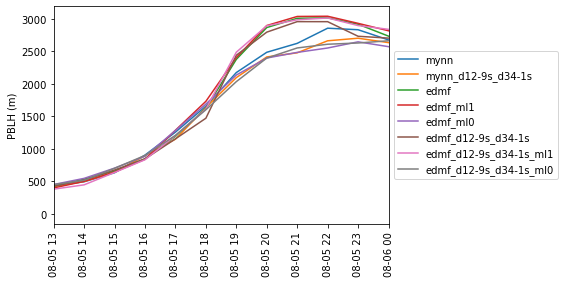

In [40]:
eval_date = '2018-08-05'

wrf_list = ['mynn', 'mynn_d12-9s_d34-1s', 
            'edmf', 'edmf_ml1', 'edmf_ml0', 
            'edmf_d12-9s_d34-1s', 'edmf_d12-9s_d34-1s_ml1', 'edmf_d12-9s_d34-1s_ml0']

for run in wrf_list:
    
    pblh_d02 = get_pblh(data_dir_df[eval_date][run], 2)

    plt.plot(pblh_d02['Time'], pblh_d02, label=run)

plt.tick_params(axis='x', rotation=90)    
plt.ylabel('PBLH (m)')
plt.xlim(np.datetime64('2018-08-05T13:00:00.000000000'), np.datetime64('2018-08-06T00:00:00.000000000'))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [32]:
pblh_d02['Time'][0].values

numpy.datetime64('2018-08-05T13:00:00.000000000')

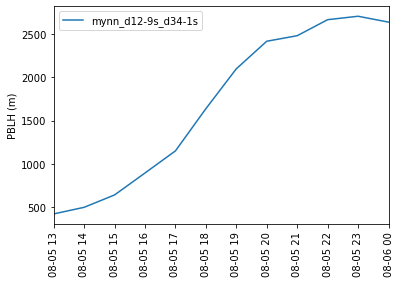

In [34]:
plt.plot(pblh_d02['Time'], pblh_d02, label=run)

plt.tick_params(axis='x', rotation=90)    
plt.ylabel('PBLH (m)')
plt.xlim(np.datetime64('2018-08-05T13:00:00.000000000'), np.datetime64('2018-08-06T00:00:00.000000000'))
plt.legend()
plt.show()

In [3]:
wrf_path = wrf_dir+'o1_0901m_30s'

pblh_d02 = get_pblh(wrf_path, 2)
pblh_d03 = get_pblh(wrf_path, 3)
pblh_d04 = get_pblh(wrf_path, 4)

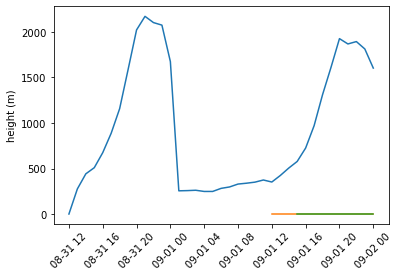

In [4]:
plt.plot(pblh_d02['Time'], pblh_d02)
plt.plot(pblh_d03['Time'], pblh_d03)
plt.plot(pblh_d04['Time'], pblh_d04)
plt.tick_params(axis='x', rotation=45)
plt.ylabel('height (m)')
plt.show()

In [5]:
# obs_dir = '/projects/mmcpnnl/sgp_obs/'
obs_dir = '/home/jlee/mmc/jlee/sgp/sgp_obs/'
# ceil_ncs = obs_dir+'sgpceilpblhtC1.a0/*.cdf' # data not good on 5 Aug
ceil_ncs = obs_dir+'sgppblhtdlC1.c1/*.nc'
ceil = xr.open_mfdataset(ceil_ncs)

In [6]:
eval_date = '2018-09-01'
ceil_target = ceil.sel(time=slice(eval_date, eval_date))
# ceil_target

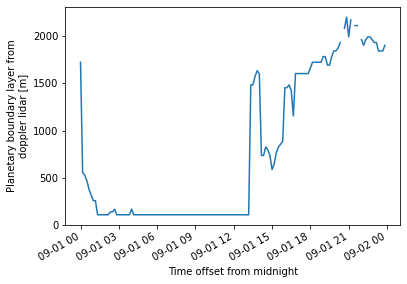

In [7]:
ceil_target['pbl_height_dl'].where(ceil_target['qc_pbl_height_dl'] <= 0).plot()

In [9]:
wrf_path = wrf_dir+'o1_0901m_30s'

pblh_d02l = get_pblh(wrf_path, 2)

In [10]:
wrf_path = wrf_dir+'o5_0901m_9s1s'

pblh_d02t = get_pblh(wrf_path, 2)

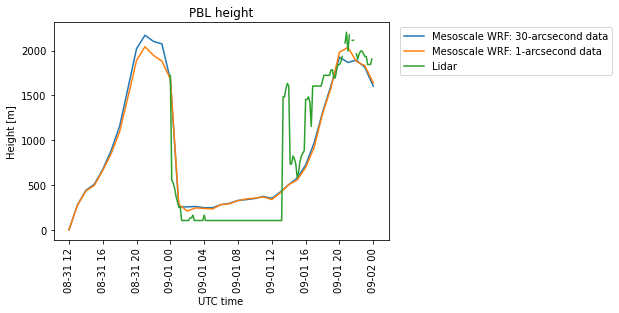

In [12]:
# plt.plot(pblh_d02['Time'], pblh_d02, label='Mesoscale WRF: 30-arcsecond land use data')
plt.plot(pblh_d02l['Time'], pblh_d02l, label='Mesoscale WRF: 30-arcsecond data')
plt.plot(pblh_d02t['Time'], pblh_d02t, label='Mesoscale WRF: 1-arcsecond data')
plt.plot(ceil_target['time'], ceil_target['pbl_height_dl'].where(ceil_target['qc_pbl_height_dl'] <= 0), label='Lidar')
plt.title('PBL height')
plt.ylabel('Height [m]')
plt.xlabel('UTC time')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',)
plt.xticks(rotation=90)
plt.show()

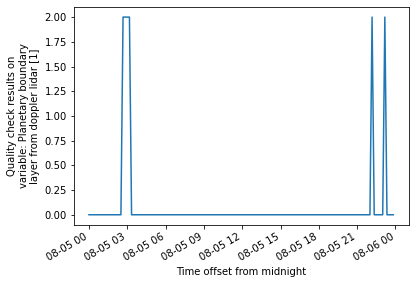

In [30]:
ceil_target['qc_pbl_height_dl'].plot()

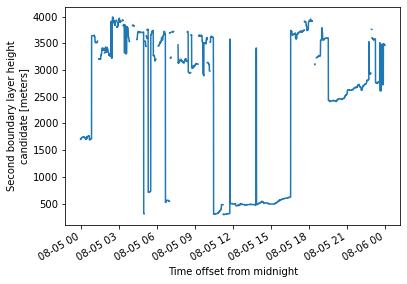

In [22]:
ceil_target['bl_height_2'].plot()

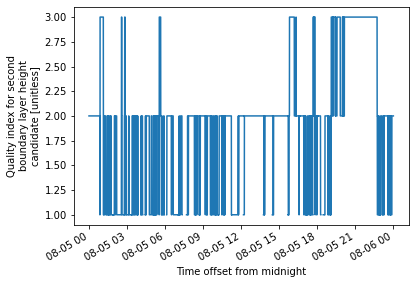

In [23]:
ceil_target['bl_index_2'].plot()

In [10]:
wrf_path = wrf_dir+'l5_0805m'

pblh_d02 = get_pblh(wrf_path, 2)
pblh_d03 = get_pblh(wrf_path, 3)
pblh_d04 = get_pblh(wrf_path, 4)

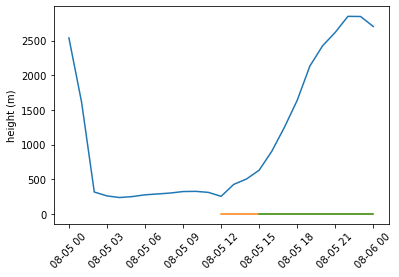

In [11]:
plt.plot(pblh_d02['Time'], pblh_d02)
plt.plot(pblh_d03['Time'], pblh_d03)
plt.plot(pblh_d04['Time'], pblh_d04)
plt.tick_params(axis='x', rotation=45)
plt.ylabel('height (m)')
plt.show()

In [43]:
pblh_d04

<xarray.DataArray 'PBLH' (Time: 10)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)
Coordinates:
    XLONG    float32 -97.48
    XLAT     float32 36.6
    XTIME    (Time) float32 1.62e+03 1.68e+03 1.74e+03 ... 2.1e+03 2.16e+03
  * Time     (Time) datetime64[ns] 2018-08-05T15:00:00 ... 2018-08-06
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  PBL HEIGHT
    units:        m
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [9]:
pblh = wrf.getvar(wrf_single, 'PBLH')

In [12]:
site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)

In [16]:
pblh_1pt = pblh[site_loc_ij.values[1], site_loc_ij.values[0]]

In [17]:
pblh_1pt

    if ind == 0: 
        ds_all = ds
    else: 
        ds_all = xr.concat([ds, ds_all], dim='Time')

<xarray.DataArray 'PBLH' ()>
array(300.84473, dtype=float32)
Coordinates:
    XLONG    float32 -97.49
    XLAT     float32 36.59
    XTIME    float32 1.2e+03
    Time     datetime64[ns] 2018-08-05T08:00:00
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  PBL HEIGHT
    units:        m
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [6]:
for ind, file in enumerate(wrf_file_list[0]):
    
    print(file)

    wrf_single = Dataset(file, 'r')

    pblh = wrf.getvar(wrf_single, 'PBLH')

/


OSError: [Errno -51] NetCDF: Unknown file format: b'/'